# Diabetes Prediction 

## Imports

In [1]:
# Data
import pandas as pd

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Computation
import numpy as np

# Preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Data 

The data set is composed of 9 columns of int and float types.<br>

- **'Pregnancies'** : Number of times pregnant
- **'Glucose'** : Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- **'BloodPressure'** : Diastolic blood pressure (mm Hg)
- **'SkinThickness'** : Triceps skin fold thickness (mm)
- **'Insulin'** : 2-Hour serum insulin (mu U/ml)
- **'BMI'** : Body mass index (weight in kg/(height in m)^2)
- **'DiabetesPedigreeFunction'** : Diabetes pedigree function
- **'Age'** : Age (years)
- **'Outcome'**: Class variable (0 or 1) 268 of 768 are 1, the others are 0

Important remark : the data concerns only woman

There are no null values in our dataset. In the case there were null values, we would use look for strategies using Imputer method.



In [2]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Columns of the dataset

In [5]:
df.columns.to_list()

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

# Exploratory Data Analysis

In the following section, we will examine class balance, analyze data distributions, explore pairwise correlations, assess feature relationships and detect potential outliers.

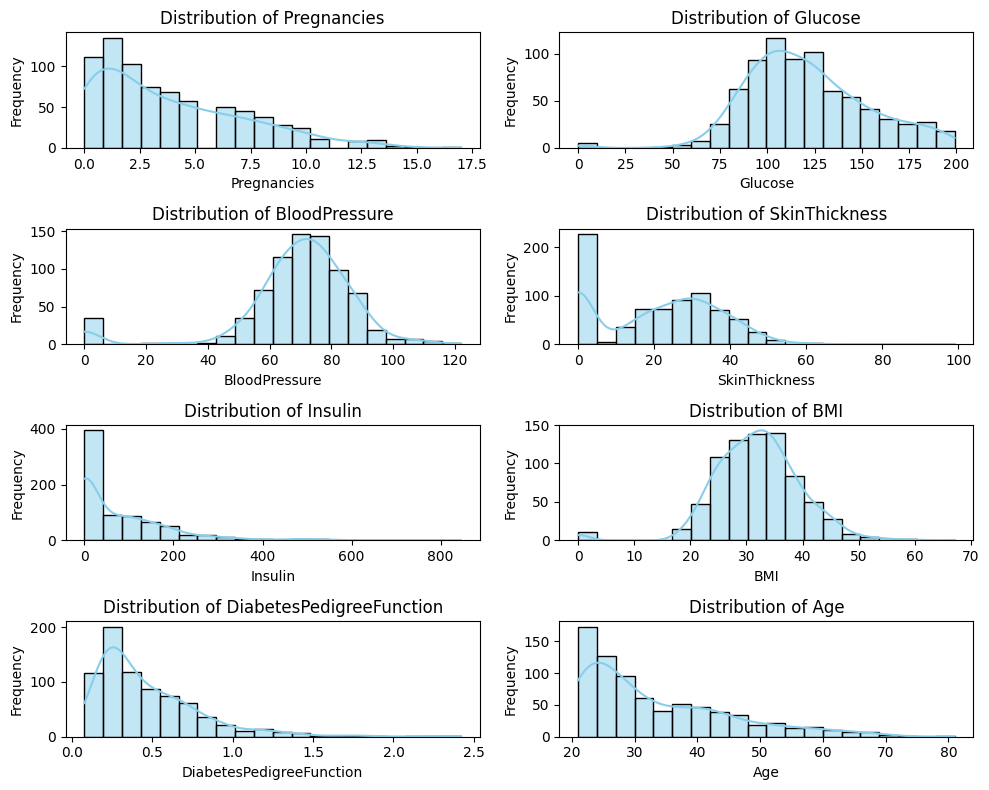

In [6]:
columns_for_plot = df.drop(columns=["Outcome"]).columns

fig, axes = plt.subplots(4, 2, figsize=(10, 8))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(columns_for_plot):  
    sns.histplot(df[col], kde=True, color='skyblue', bins=20, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**observation**:

Based on the previous distribution plots, we observe some undesired values. Although there is no null value in the dataset, there is a high frequency of 0's in Glucose, Blood Preasure, Skin thickness, Insulin and Body mass index (BMI)


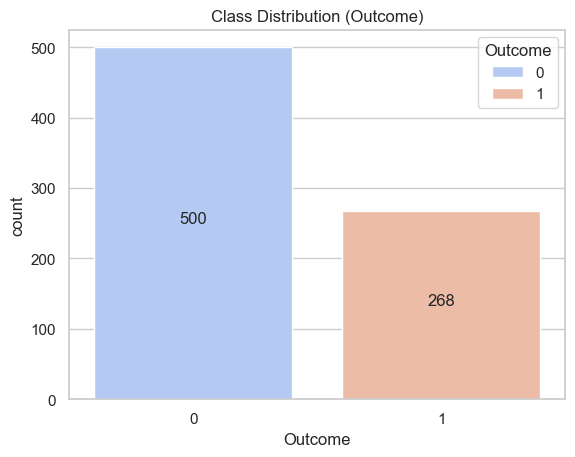

In [125]:
# Class distribution
counts = df['Outcome'].value_counts()

# Plot class distribution
sns.countplot(x='Outcome', data=df, palette='coolwarm', hue='Outcome')
plt.title('Class Distribution (Outcome)')
plt.text(x=0, y=int(counts[0]/2), s=f"{counts[0]}", ha='center', fontsize=12)
plt.text(x=1, y=int(counts[1]/2), s=f"{counts[1]}", ha='center', fontsize=12)
plt.show()

**observation:** We observe class is **imbalanced**, there are more data samples of non-diabetic patients (class 0) compared to diabetic patients (class 1).<br>This imbalance can lead to biased model performance, where the model may favor predicting the majority class. To address this, we need to oversample the minority class (diabetic patients, class 1) to balance the dataset and improve model performance.


To address the class imbalance we will apply **SMOTE (Synthetic Minority Over-sampling Technique)**

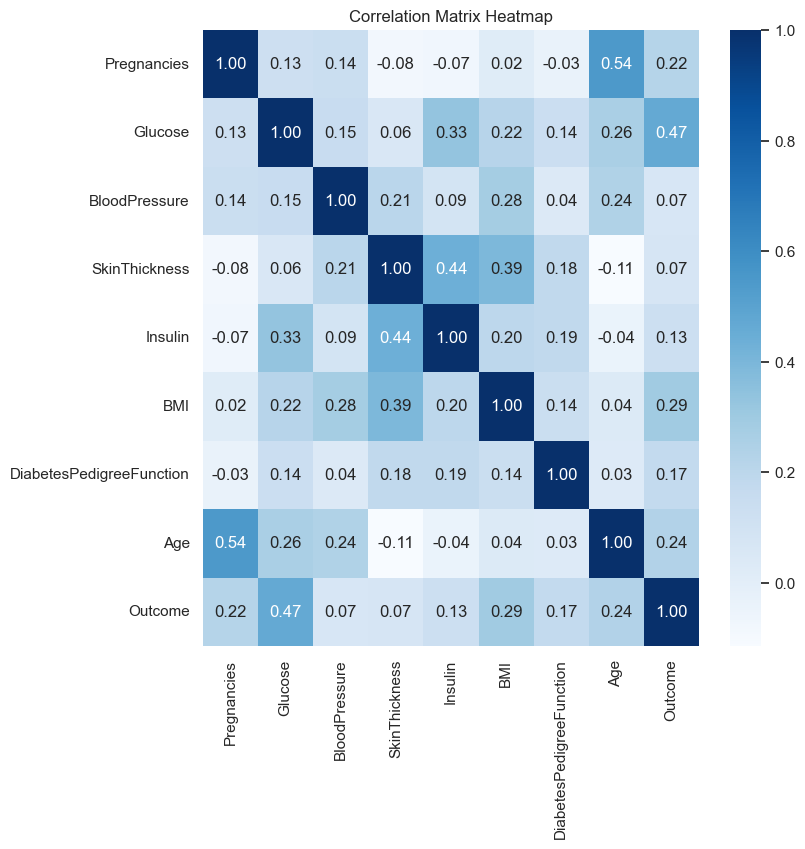

In [126]:
corr_matrix = df.corr()

# Heatmap of correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

The target 'Outcome' is less correlated with 'BloodPressure' and 'SkinThickness'. They are potential features to drop. 

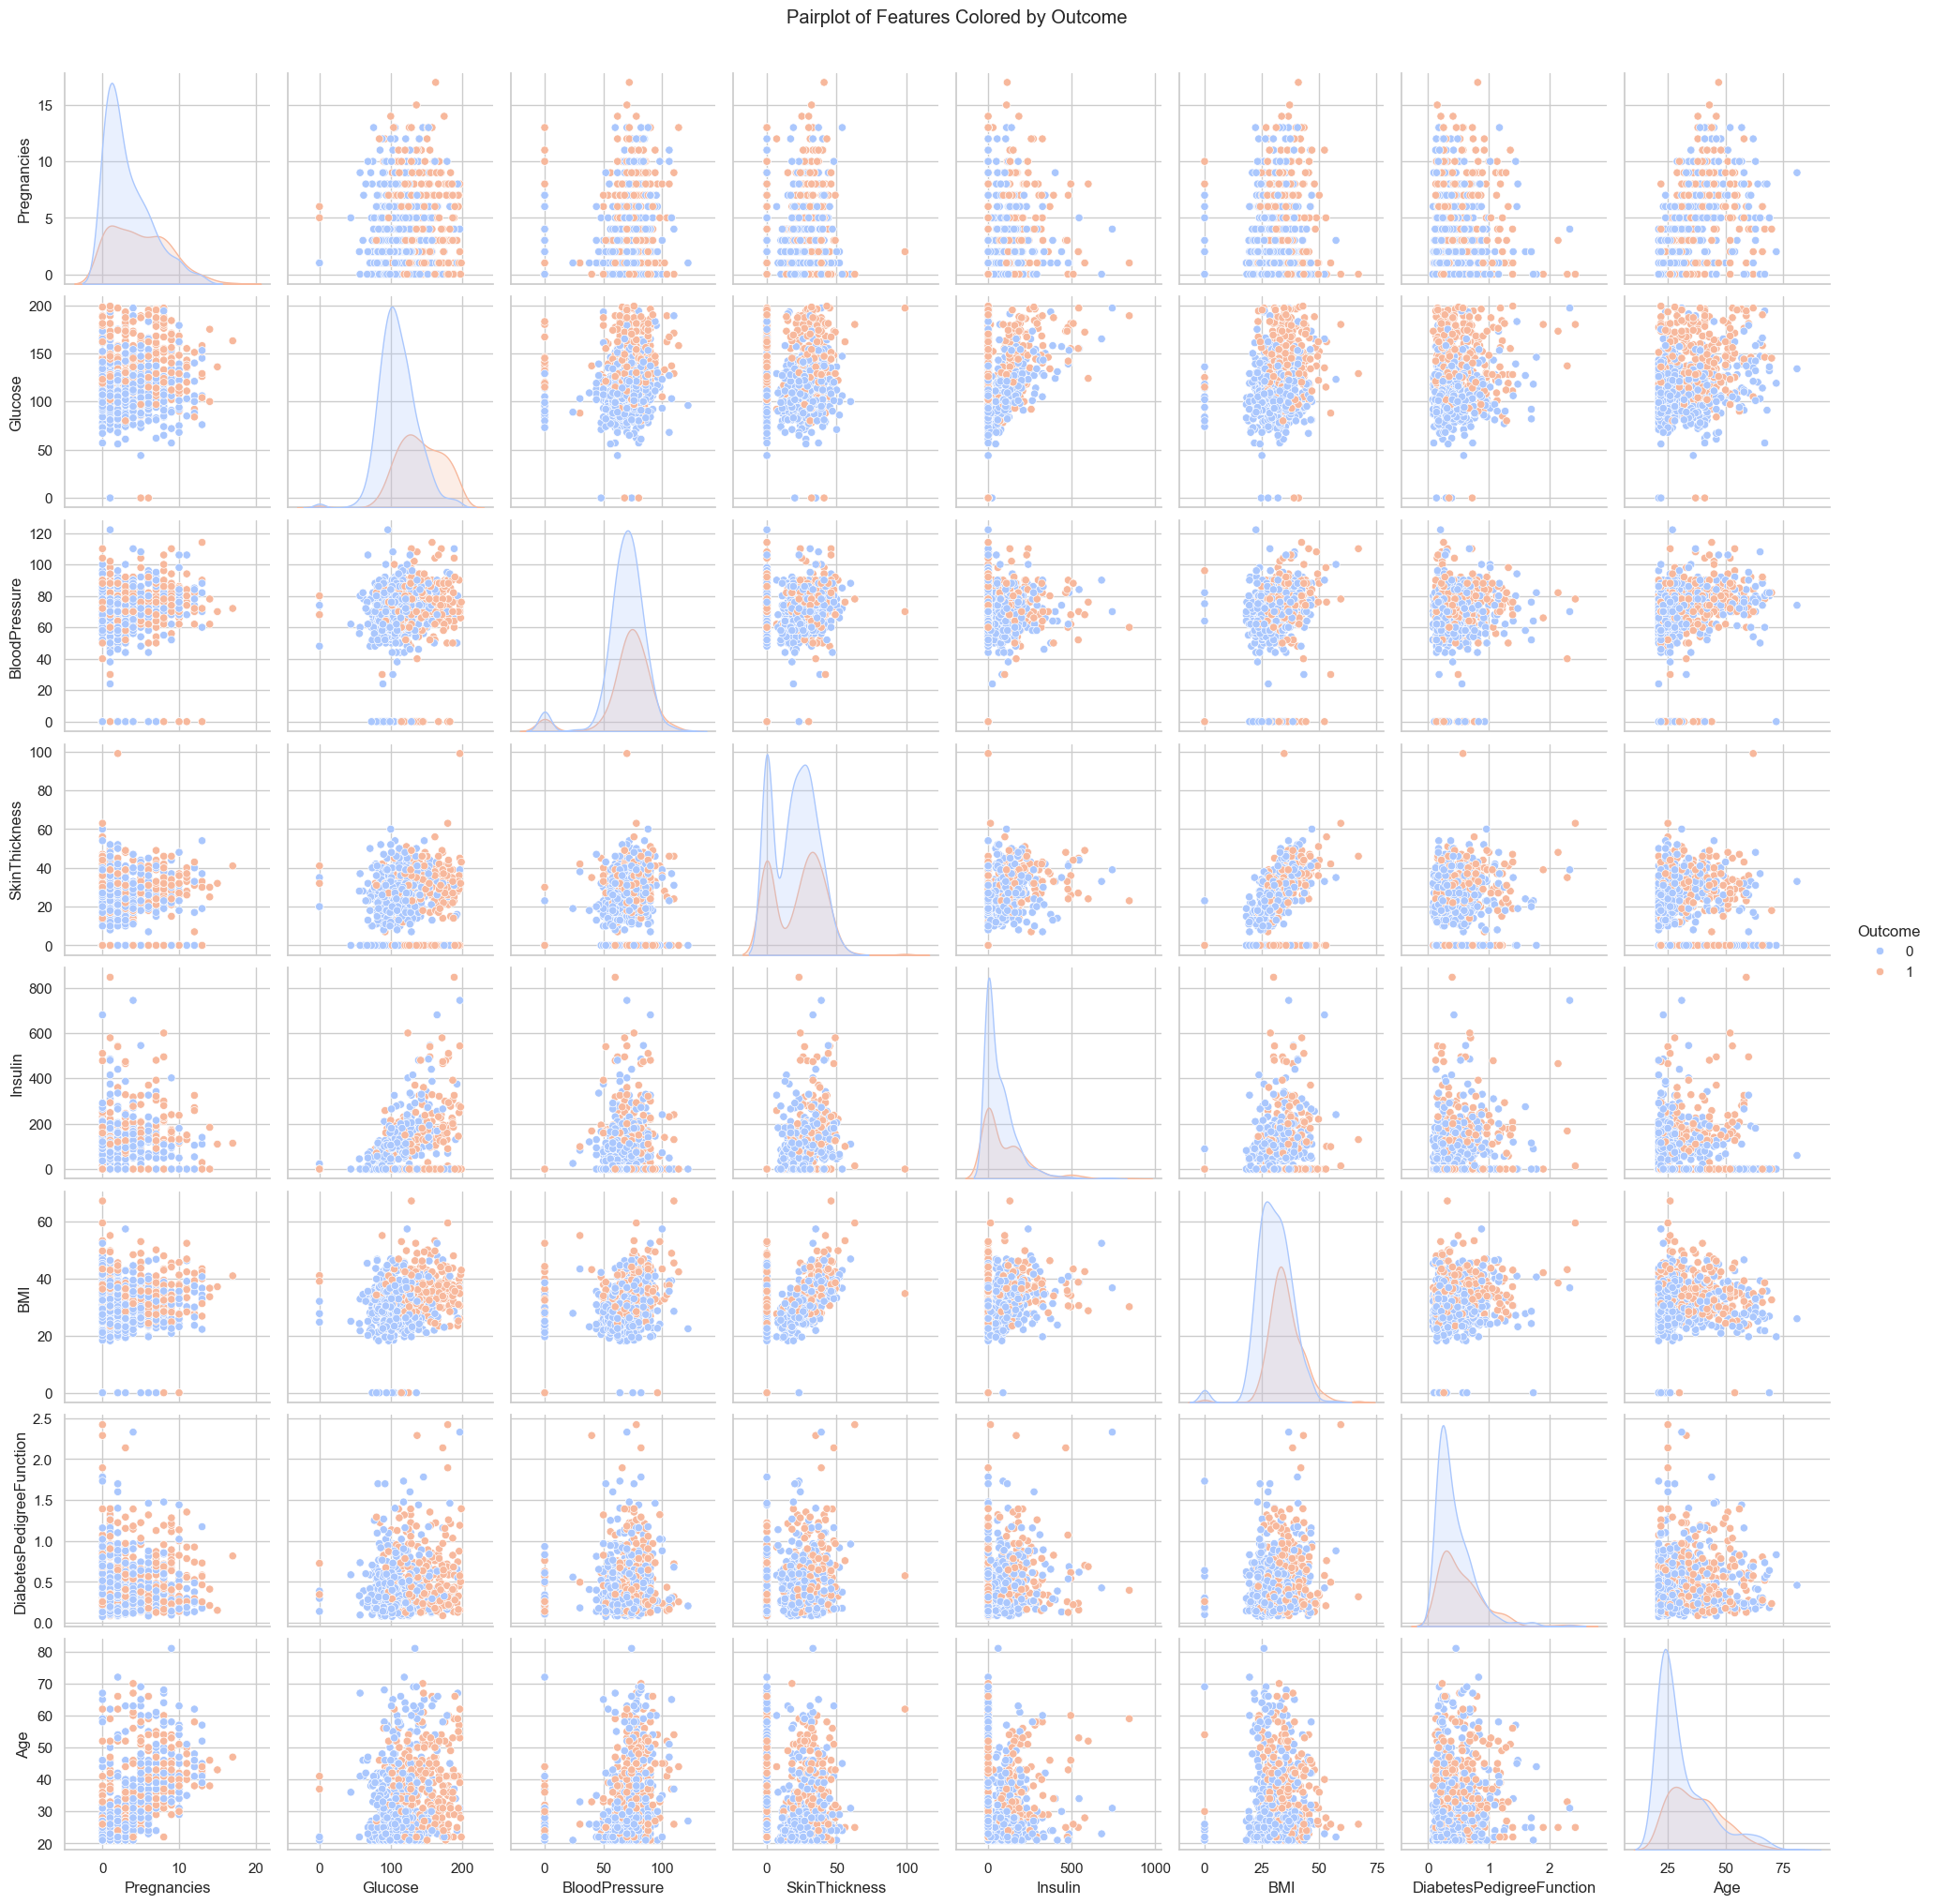

In [127]:
# Pairplot of numerical features
sns.pairplot(df, hue='Outcome', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairplot of Features Colored by Outcome', y=1.02)
plt.show()

In [128]:
# Boxplots for Outlier Detection (numerical features)
# Create a boxplot for each feature
fig = px.box(df, y=columns_for_plot, title="Boxplot of Features")
fig.show()


From the previous boxplot, it is clear that the primary outliers are from the "Insulin" feature, where the values are significantly higher.

We need to delete outliers data for 

In [129]:
columns_for_plot

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [130]:
# 2 by 4 grid of boxplots
for i in columns_for_plot:
    fig = px.box(df, y=i, title="Boxplot of Features")
    fig.show()

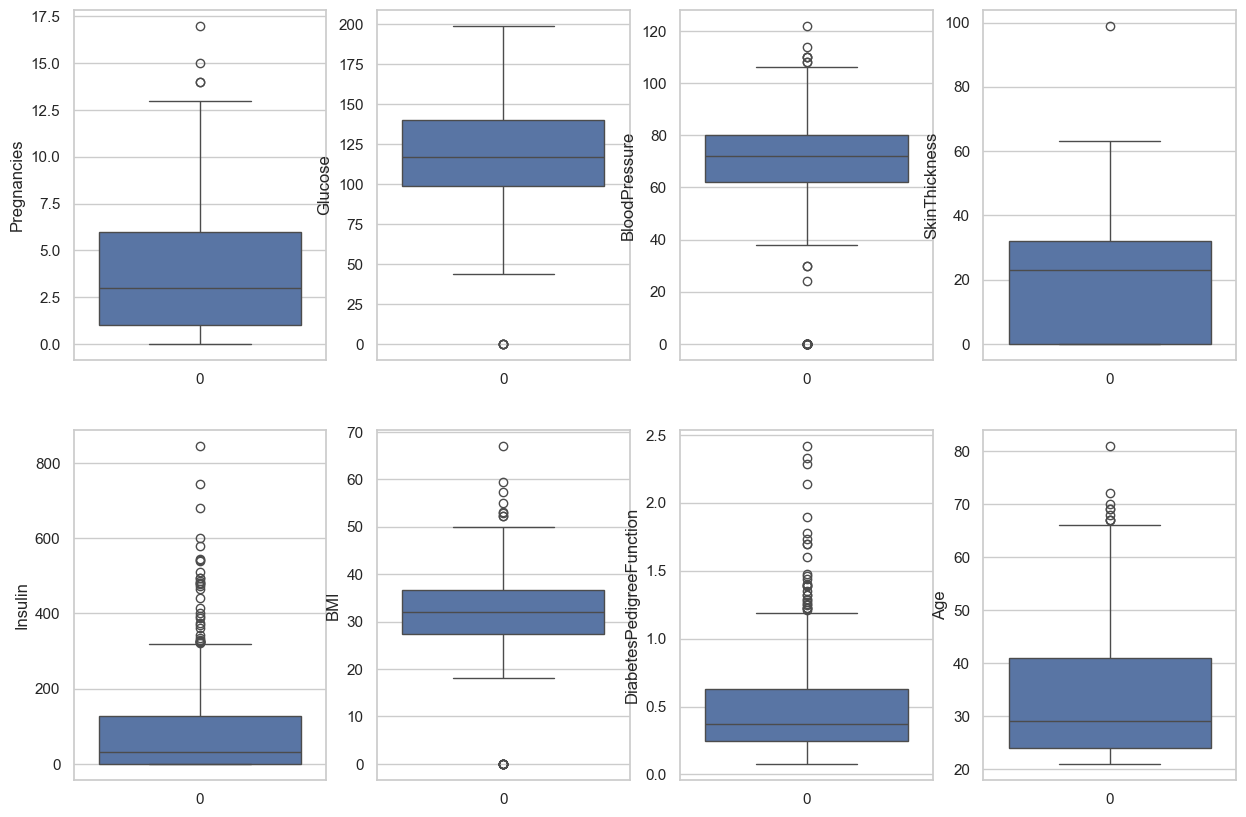

In [131]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i in range(2):
    for j in range(4):
        sns.boxplot(x=0, y=columns_for_plot[i*4+j], data=df, ax=axes[i, j])

## Data cleaning

## Pipeline with less data 

we remove data where insulin is 0.

In [47]:
df_1 = df.copy()

# to remove the data with zero value in Insulin
df_1 = df_1[df_1['Insulin'] > 0]

# Replace suspicious zero values with NaN in Insulin and SkinThickness
zero_to_nan_features = ['SkinThickness', 'BMI', 'Glucose']
df_1[zero_to_nan_features] = df_1[zero_to_nan_features].replace(0, np.nan)

# Replace suspicious very low values in BloodPressure to NaN
df_1.loc[df_1['BloodPressure'] < 30, 'BloodPressure'] = np.nan

# Replace suspicious very high values in Pregnancies to NaN
df_1.loc[df_1['Pregnancies'] >= 11, 'Pregnancies'] = np.nan

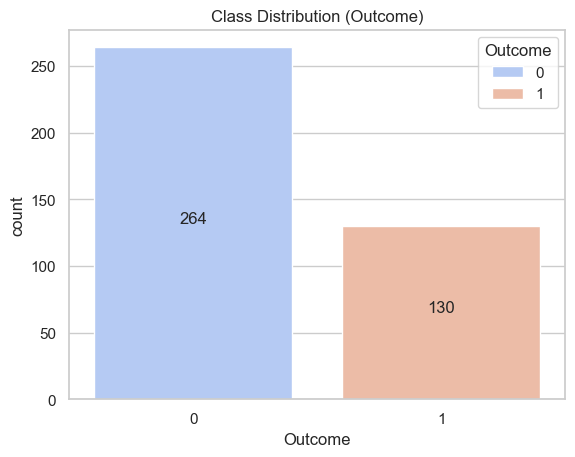

In [48]:
# Class distribution
counts = df_1['Outcome'].value_counts()

# Plot class distribution
sns.countplot(x='Outcome', data=df_1, palette='coolwarm', hue='Outcome')
plt.title('Class Distribution (Outcome)')
plt.text(x=0, y=int(counts[0]/2), s=f"{counts[0]}", ha='center', fontsize=12)
plt.text(x=1, y=int(counts[1]/2), s=f"{counts[1]}", ha='center', fontsize=12)
plt.show()

In [49]:
# Separate features and target
X = df_1.drop("Outcome", axis=1)
y = df_1["Outcome"]

In [50]:
### PIPELINE ###
# Identify numerical columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns


# Columns for imputation strategy

median_impute_cols = [
    'SkinThickness', 
    'DiabetesPedigreeFunction',
    'Age',
    'Pregnancies'
]

mean_impute_cols = [
    'Glucose',
    'BloodPressure',
    'BMI'
]


# Separate transformers for each imputation strategy

median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing for both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('median_features', median_transformer, median_impute_cols),
        ('mean_features', mean_transformer, mean_impute_cols)
    ],
    remainder='passthrough'
)


# Add class imbalance handling with SMOTE
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),                      # Preprocessing step
    ("smote", SMOTE(random_state=42)),                   # Oversample the minority class
    #("feature_selection", SelectFromModel(RandomForestClassifier(random_state=42))),  # Feature selection
    ("classifier", LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))  # Classifier
])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# stratify to ensure class balance in training and test sets

# Use StratifiedKFold for preserving class distribution in splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline Evaluation
cv_scores = cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=cv, scoring="roc_auc")

print("Cross-Validation AUC Scores:", cv_scores)
print("Mean CV AUC:", np.mean(cv_scores))

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]


# Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

/Users/amarnathe/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

/Users/amarnathe/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

/Users/amarnathe/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

/Users/amarnathe/Library/Python/3.9/lib/python/site-packages/sklearn/base

Cross-Validation AUC Scores: [0.83837209 0.74943311 0.89229025 0.81519274 0.86961451]
Mean CV AUC: 0.832980541053631

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        53
           1       0.73      0.85      0.79        26

    accuracy                           0.85        79
   macro avg       0.83      0.85      0.83        79
weighted avg       0.86      0.85      0.85        79

ROC-AUC Score: 0.8831640058055152


/Users/amarnathe/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

/Users/amarnathe/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



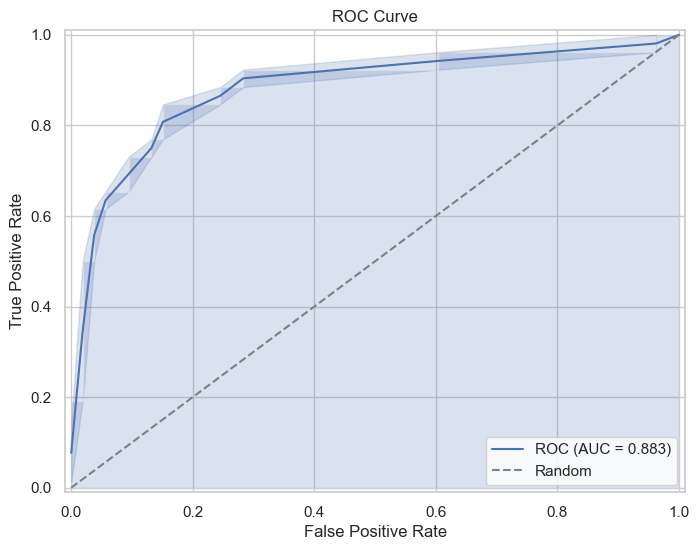

In [51]:
from sklearn.metrics import roc_curve, auc

def plot_roc_sns(y_test, y_prob):
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create plot
    plt.figure(figsize=(8, 6))
    
    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linestyle='-', label=f'ROC (AUC = {roc_auc:.3f})')
    
    # Add diagonal line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    
    # Customize plot
    plt.fill_between(fpr, tpr, alpha=0.2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Set axis limits
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    
    return plt.gcf()

# Usage
y_prob = pipeline.predict_proba(X_test)[:, 1]
fig = plot_roc_sns(y_test, y_prob)
plt.show()

## Pipeline without removing data

In [52]:
print("Number of zero value for Insulin:",df[df['Insulin'] > 0]['Insulin'].count())

Number of zero value for Insulin: 394


We will handle missing values by applying median value and we will use SMOTE to oversample the imbalanced class.

In [53]:
from sklearn.impute import SimpleImputer, KNNImputer

In [72]:
df_1 = df.copy()

# Replace suspicious zero values with NaN in Insulin and SkinThickness
zero_to_nan_features = ['Insulin', 'SkinThickness', 'BMI', 'Glucose']
df_1[zero_to_nan_features] = df_1[zero_to_nan_features].replace(0, np.nan)

# Replace suspicious very low values in BloodPressure to NaN
df_1.loc[df_1['BloodPressure'] < 30, 'BloodPressure'] = np.nan

# Replace suspicious very high values in Pregnancies to NaN
df_1.loc[df_1['Pregnancies'] >= 11, 'Pregnancies'] = np.nan

df_1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [73]:
# Separate features and target
X = df_1.drop("Outcome", axis=1)
y = df_1["Outcome"]

In [74]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



Training SVC...

SVC Results:
Cross-validation scores: [0.83314815 0.84259259 0.80351852 0.83584906 0.79056604]
Average CV score: 0.821 (+/- 0.041)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       100
           1       0.63      0.67      0.65        54

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154


Confusion Matrix:


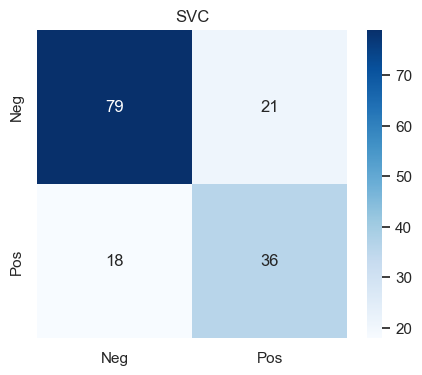


ROC AUC Score: 0.813
-----------------------------------------------------

Training LogisticRegression...

LogisticRegression Results:
Cross-validation scores: [0.82203704 0.87203704 0.8462963  0.82396226 0.80396226]
Average CV score: 0.834 (+/- 0.047)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       100
           1       0.57      0.65      0.61        54

    accuracy                           0.71       154
   macro avg       0.68      0.69      0.69       154
weighted avg       0.72      0.71      0.71       154


Confusion Matrix:


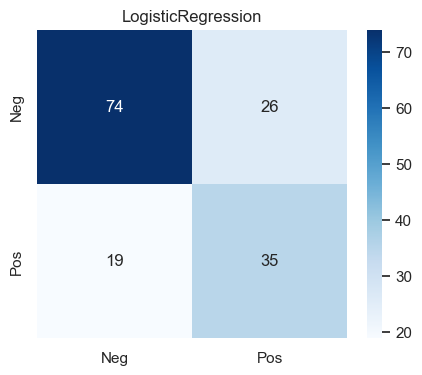


ROC AUC Score: 0.805
-----------------------------------------------------

Training KNN...

KNN Results:
Cross-validation scores: [0.78472222 0.80537037 0.77731481 0.78933962 0.78122642]
Average CV score: 0.788 (+/- 0.019)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       100
           1       0.55      0.70      0.62        54

    accuracy                           0.69       154
   macro avg       0.68      0.70      0.68       154
weighted avg       0.72      0.69      0.70       154


Confusion Matrix:


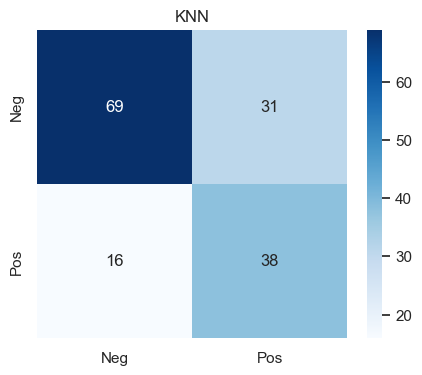


ROC AUC Score: 0.761
-----------------------------------------------------

Training Random Forest...

Random Forest Results:
Cross-validation scores: [0.83944444 0.81601852 0.85074074 0.83226415 0.78698113]
Average CV score: 0.825 (+/- 0.044)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       100
           1       0.61      0.70      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154


Confusion Matrix:


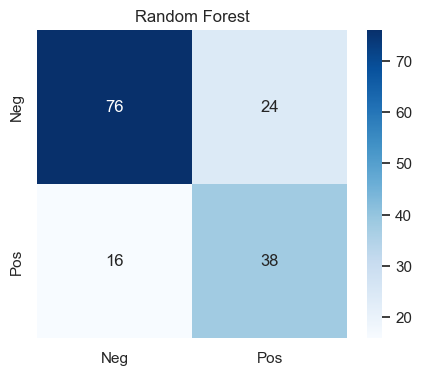


ROC AUC Score: 0.820
-----------------------------------------------------


In [108]:
### PIPELINE ###
# Identify numerical columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns


# Columns for imputation strategy
insulin_col = ['Insulin']

median_impute_cols = [
    'SkinThickness', 
    'DiabetesPedigreeFunction',
    'Age',
    'Pregnancies'
]

mean_impute_cols = [
    'Glucose',
    'BloodPressure',
    'BMI'
]


# Separate transformers for each imputation strategy
insulin_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=10, weights='distance')),
    ('scaler', StandardScaler())
])

median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine preprocessing for both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('insulin_features', insulin_transformer, insulin_col),
        ('median_features', median_transformer, median_impute_cols),
        ('mean_features', mean_transformer, mean_impute_cols)
    ],
    remainder='passthrough'
)


classifiers = {
        'SVC': ImbPipeline([
            ('preprocessor', preprocessor),
            ("smote", SMOTE(random_state=42)),
            #("feature_selection", SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classifier', SVC(kernel='rbf', probability=True, random_state=42, gamma='scale', C=1.0))
        ]),
        'LogisticRegression': ImbPipeline([
            ('preprocessor', preprocessor),
            ("smote", SMOTE(random_state=42)),
            #("feature_selection", SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"))
        ]),
        
        'KNN': ImbPipeline([
            ('preprocessor', preprocessor),
            ("smote", SMOTE(random_state=42)),
            #("feature_selection", SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classifier', KNeighborsClassifier(n_neighbors=5))
        ]),
        
        'Random Forest': ImbPipeline([
            ('preprocessor', preprocessor),
            ("smote", SMOTE(random_state=42)),
            #("feature_selection", SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classifier', RandomForestClassifier(
                n_estimators=100, 
                max_depth=10,
                random_state=42
            ))
        ])
    }


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# stratify to ensure class balance in training and test sets

# Use StratifiedKFold for preserving class distribution in splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Train and evaluate each classifier
results = {}
final = []
for name, pipeline in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="roc_auc")
    
    # Store results
    results[name] = {
        'pipeline': pipeline,
        'cv_scores': cv_scores,
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(results[name]['classification_report'])
    print("\nConfusion Matrix:")

    plt.figure(figsize=(5, 4))
    sns.heatmap(results[name]['confusion_matrix'], 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=['Neg', 'Pos'],
                yticklabels=['Neg', 'Pos'])
    plt.title(f'{name}')
    plt.show()
    

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.3f}")

    final.append({"name": name, "avg_cv_score": cv_scores.mean(), "std_cv_score": cv_scores.std(), "roc_auc": roc_auc, "accuracy_score": accuracy_score(y_test, y_pred), "f1_score": f1_score(y_test, y_pred), "precision_score": precision_score(y_test, y_pred), "recall_score": recall_score(y_test, y_pred)})

    print("-----------------------------------------------------")


# Print best model based on CV score
best_model = max(results.items(), 
                key=lambda x: x[1]['cv_scores'].mean())
#print(f"\nBest performing model: {best_model[0]}")
#print(f"Average CV score: {best_model[1]['cv_scores'].mean():.3f}")


In [107]:
y_test.value_counts()

Outcome
0    100
1     54
Name: count, dtype: int64

In [104]:
results[name]['confusion_matrix']

array([[76, 24],
       [16, 38]])

In [109]:
final_df = pd.DataFrame(final)
final_df.head()

,name,avg_cv_score,std_cv_score,roc_auc,accuracy_score,f1_score,precision_score,recall_score
0,SVC,0.821135,0.020328,0.813333,0.746753,0.648649,0.631579,0.666667
1,LogisticRegression,0.833659,0.023425,0.805000,0.707792,0.608696,0.573770,0.648148
2,KNN,0.787595,0.009731,0.760741,0.694805,0.617886,0.550725,0.703704
3,Random Forest,0.825090,0.022136,0.819630,0.740260,0.655172,0.612903,0.703704
